In [1]:
library("metacell")
library("Matrix")
library("ggplot2")
library("ggrepel")
library("tgstat")
library("zoo")
library("qvalue")
library("devtools")
library("data.table")
library("tidyverse")
library("tglkmeans")
library('RColorBrewer')


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: usethis

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.3     v dplyr   1.0.9
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.0     v forcats 0.5.1
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x tidyr::expand()    masks Matrix::expand()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x tidyr::pack()      masks Matrix::pack()
x purrr::transpose() masks data.table::transpose()
x tidyr::unpack()    masks Matrix::unpack()



In [2]:
scdb_init("../scrna_db/", force_reinit=T)

fig_dir <- "../figs/"
if(!dir.exists(fig_dir)) dir.create(fig_dir)
scfigs_init(fig_dir)

mat_exe <- scdb_mat("exe")
mc_exe <- scdb_mc("exe")
md_exe <- mat_exe@cell_metadata[names(mc_exe@mc),]

mat_emb <- scdb_mat("emb")
mc_emb <- scdb_mc("emb")
md_emb <- mat_emb@cell_metadata[names(mc_emb@mc),]

mat_embexe <- scdb_mat("embexe")
mc_embexe <- scdb_mc("embexe_recolored")
md_embexe <- mat_embexe@cell_metadata[names(mc_embexe@mc),]

initializing scdb to ../scrna_db/



In [3]:
color_key <- mc_embexe@color_key

col_to_ct = color_key$group
names(col_to_ct) = color_key$color

ct_to_col = color_key$color
names(ct_to_col) = color_key$group

mcs_ordered <- mc_emb@colors
names(mcs_ordered) <- 1:length(mcs_ordered)

mcs_ordered <- mcs_ordered[order(factor(mcs_ordered, levels = c(color_key$color[1:41])))]

annotation_col = data.frame(ct = col_to_ct[mc_exe@colors],stringsAsFactors = F)
rownames(annotation_col) = c(1:nrow(annotation_col))
annotation_colors = list(ct = ct_to_col)

shades_rdbu <- rev(colorRampPalette(RColorBrewer::brewer.pal(11,name = "RdBu"))(100))
shades_blues <- colorRampPalette(RColorBrewer::brewer.pal(9,"Blues"))(100)
shades_reds <- colorRampPalette(RColorBrewer::brewer.pal(9,"Reds"))(100)
shades_yellows <- colorRampPalette(RColorBrewer::brewer.pal(9,"YlOrBr"))(100)
shades_greys <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greys"))(100)
shades_greens <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greens"))(100)
shades_purples <- colorRampPalette(RColorBrewer::brewer.pal(9,"BuPu"))(100)

chorion_cls = names(mc_exe@mc)[mc_exe@colors[mc_exe@mc] == mc_exe@color_key$color[1]]
tsc_cls = names(mc_exe@mc)[mc_exe@colors[mc_exe@mc] == mc_exe@color_key$color[2]]
tsc2_cls = names(mc_exe@mc)[mc_exe@colors[mc_exe@mc] == mc_exe@color_key$color[3]]
spt_cls = names(mc_exe@mc)[mc_exe@colors[mc_exe@mc] == mc_exe@color_key$color[4]]
epc_cls = names(mc_exe@mc)[mc_exe@colors[mc_exe@mc] == mc_exe@color_key$color[5]]
tgc_cls = names(mc_exe@mc)[mc_exe@colors[mc_exe@mc] == mc_exe@color_key$color[6]]
ptsc_cls = names(mc_exe@mc)[mc_exe@colors[mc_exe@mc] == mc_exe@color_key$color[7]]
spa_cls = names(mc_exe@mc)[mc_exe@colors[mc_exe@mc] == mc_exe@color_key$color[8]]

chorion_mcs = which(mc_exe@colors == mc_exe@color_key$color[1])
tsc_mcs = which(mc_exe@colors == mc_exe@color_key$color[2])
tsc2_mcs = which(mc_exe@colors == mc_exe@color_key$color[3])
spt_mcs = which(mc_exe@colors == mc_exe@color_key$color[4])
epc_mcs = which(mc_exe@colors == mc_exe@color_key$color[5])
tgc_mcs = which(mc_exe@colors == mc_exe@color_key$color[6])
ptsc_mcs = which(mc_exe@colors == mc_exe@color_key$color[7])
spa_mcs = which(mc_exe@colors == mc_exe@color_key$color[8])

mc_time <- tapply(md_exe$developmental_time, mc_exe@mc[rownames(md_exe)], mean)
mc_new_ord = as.numeric(names(mc_time[order(as.numeric(mc_time))]))

chorion_mcs_ord = mc_new_ord[which(mc_new_ord %in% chorion_mcs)]
tsc_mcs_ord = mc_new_ord[which(mc_new_ord %in% tsc_mcs)]
tsc2_mcs_ord = mc_new_ord[which(mc_new_ord %in% tsc2_mcs)]
spt_mcs_ord = mc_new_ord[which(mc_new_ord %in% spt_mcs)]
epc_mcs_ord = mc_new_ord[which(mc_new_ord %in% epc_mcs)]
tgc_mcs_ord = mc_new_ord[which(mc_new_ord %in% tgc_mcs)]
ptsc_mcs_ord = mc_new_ord[which(mc_new_ord %in% ptsc_mcs)]
spa_mcs_ord = mc_new_ord[which(mc_new_ord %in% spa_mcs)]

mcs_all <- c(tsc_mcs_ord,chorion_mcs_ord,tsc2_mcs_ord,spt_mcs_ord,epc_mcs_ord,tgc_mcs_ord,spa_mcs_ord,ptsc_mcs_ord)
mcs_epc_lineage <- c(tgc_mcs_ord,epc_mcs_ord,spt_mcs_ord)
mcs_chorion_lineage <- c(tsc_mcs_ord,chorion_mcs_ord,tsc2_mcs_ord)

library(dplyr)

exe_cells = rownames(md_exe)[md_exe$Experiment != "Wildtype project"]
exe_cells_f = exe_cells[!is.na(md_exe[exe_cells,"time_bin"])]

emb_age_df = unique(md_exe[exe_cells_f,c("embryo","transcriptional_rank",
                                                    "time_bin","developmental_time")])
emb_age_df = emb_age_df[order(emb_age_df$transcriptional_rank),]
sc_time_annot = data.frame(cell = exe_cells_f,
                           embryo = md_exe[exe_cells_f,"embryo"])
sc_time_annot = left_join(sc_time_annot,emb_age_df,by = "embryo")
f = !is.na(sc_time_annot$developmental_time)
sc_time = sc_time_annot$developmental_time[f]
names(sc_time) = sc_time_annot$cell[f]

emb_ranks <- read.csv(file = "../data/embexe_age_morph_rank.csv")
emb_ranks <- emb_ranks[!is.na(emb_ranks$transcriptional_rank),]
emb_ranks <- emb_ranks[order(emb_ranks$transcriptional_rank,decreasing = F),]
age_group_cols = c(RColorBrewer::brewer.pal(9,"OrRd")[2:8],RColorBrewer::brewer.pal(9,"PuBu")[2:8],RColorBrewer::brewer.pal(9,"YlGn")[3:5])
emb_ranks$color = age_group_cols[emb_ranks$age_group]
emb_ranks$morph.rank <- NA

emb_cols <- mc_embexe@color_key$color[1:42]
exe_cols <- mc_embexe@color_key$color[43:50]
exe_cls <- names(mc_embexe@mc)[mc_embexe@colors[mc_embexe@mc] %in% exe_cols]
emb_cls <- names(mc_embexe@mc)[mc_embexe@colors[mc_embexe@mc] %in% emb_cols] 

In [4]:
### EDF2a ###
source("../scripts/plot_network.r")

mm_mctnetwork_plot_net(mct_id = "emb",
                       fn = "../figs/Embryonic_flow.pdf",
                       w = 20, h = 20,
                       dx_back = 0,
                       plot_pdf = T,
                       colors_ordered = rev(color_key$color[1:41]),
                       show_axes = F,
                       show_over_under_flow = F,
                       mc_cex = 1,
                       max_lwd = 1,
                       edge_w_scale = 2e-5,
                       plot_mc_ids = F)

gset <- scdb_gset(id = "emb_marker")
feature.genes <- names(gset@gene_set)

find_mcs <- function(color, mc){
    
    metacell_obj <- get(x = mc, envir = .GlobalEnv)
    Ct = color_key$group[color_key$color == color]
    Ct_nm_adjust <- gsub("/| |-", replacement = "_", x = Ct)
    
    mcs <- which(metacell_obj@colors == color)
    assign(x = sprintf("%s_mcs", tolower(Ct_nm_adjust)), value = mcs, envir = .GlobalEnv)
}

for(col in color_key$color){find_mcs(col, "mc_emb")}

for(ct in color_key$group[c(1:41)]){
    
    Ct <- gsub("/| |-", replacement = "_", x = ct)
    Ct_mcs <- get(sprintf("%s_mcs", tolower(Ct)))
    
    legc = log2(mc_emb@e_gc + 1e-5)
    legc_n <- legc - rowMeans(legc)

    gexp1 <- rowMeans(legc_n[intersect(feature.genes, rownames(mc_emb@e_gc)),Ct_mcs])
    gexp2 <- rowMeans(legc_n[intersect(feature.genes, rownames(mc_emb@e_gc)),-(Ct_mcs)])

    diff <- gexp1 - gexp2
#     Ct_gns <- names(diff)[diff > 3]
    Ct_gns <- names(head(sort(diff,decreasing = T),n = 2))
    assign(x = sprintf("gmod_%s", tolower(Ct)), value = Ct_gns, envir = .GlobalEnv)    
}

gmod_epiblast <- c(gmod_epiblast, "Sox3")
gmod_pgc <- c(gmod_pgc, "Dppa3")

gns_to_plot <- c()

for(cell_tp in color_key$group[c(1:41)]){
    Ct <- gsub("/| |-", replacement = "_", x = cell_tp)
    Ct_gm <- as.vector(get(sprintf("gmod_%s", tolower(Ct))))
    gns_to_plot <- c(gns_to_plot, Ct_gm) 
        
}

legc = log2(mc_emb@e_gc + 1e-5)
legc_n = legc - rowMeans(legc)
legc_nf = legc_n[unique(gns_to_plot),rev(names(mcs_ordered))]
legc_nf = pmax(legc_nf,0)
legc_nf = pmin(legc_nf,6)

annotation_col = data.frame(ct = col_to_ct[mc_emb@colors],stringsAsFactors = F)
rownames(annotation_col) = c(1:nrow(annotation_col))
annotation_colors = list(ct = ct_to_col)

options(repr.plot.width=12, repr.plot.height=10)

p <- pheatmap::pheatmap(mat = t(legc_nf), 
                        cluster_cols = F,
                        cluster_rows = F,
                        show_colnames = T,
                        show_rownames = F,
                        legend = T,
                        annotation_legend = F,
                        color = shades_blues,
                        annotation_row = annotation_col,
                        border_color = NA,
                        annotation_colors = annotation_colors)

print(p)

png 
  2

ERROR: Error in eval(expr, envir, enclos): trying to get slot "gene_set" from an object of a basic class ("NULL") with no slots


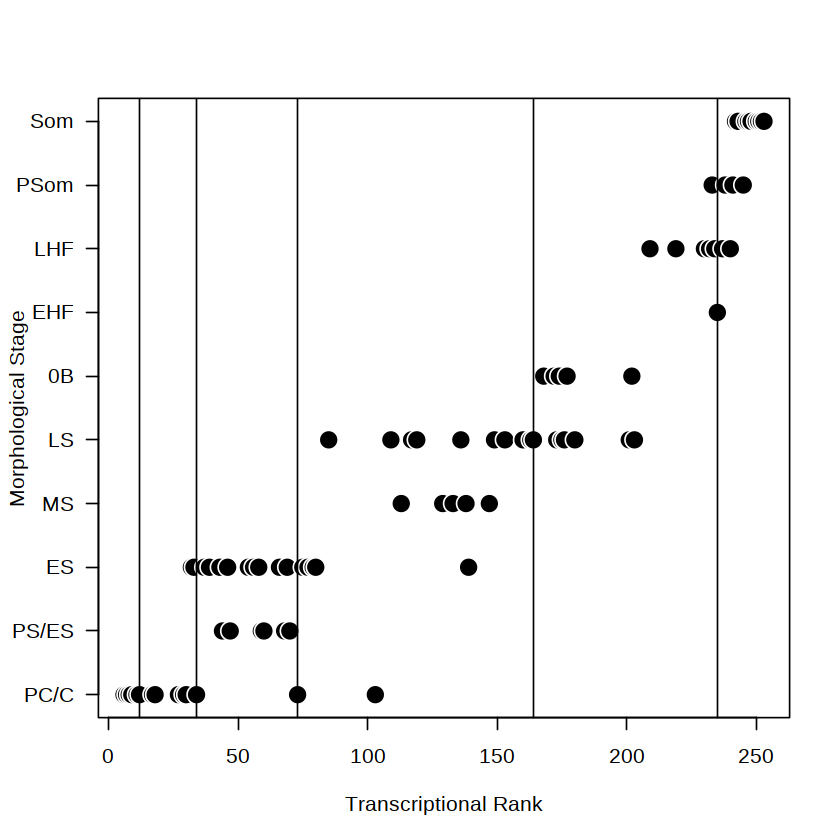

In [5]:
### EDF2b ###
rank_morph_df <- unique(mat_exe@cell_metadata[exe_cells_f,c("embryo","transcriptional_rank")])
rank_morph_df <- rank_morph_df[!is.na(rank_morph_df$transcriptional_rank),]
rank_morph_df <- rank_morph_df[order(rank_morph_df$transcriptional_rank),]
rank_morph_df = left_join(rank_morph_df,emb_ranks,by = "embryo")

rank_morph_df$morphological_stage_new[rank_morph_df$morphological_stage == "pre cavitated/cavitated"] <- "PC/C"
rank_morph_df$morphological_stage_new[rank_morph_df$morphological_stage == "pre streak/early streak"] <- "PS/ES"
rank_morph_df$morphological_stage_new[rank_morph_df$morphological_stage == "early streak"] <- "ES"
rank_morph_df$morphological_stage_new[rank_morph_df$morphological_stage == "mid streak"] <- "MS"
rank_morph_df$morphological_stage_new[rank_morph_df$morphological_stage == "late streak"] <- "LS"
rank_morph_df$morphological_stage_new[rank_morph_df$morphological_stage == "no bud"] <- "0B"
rank_morph_df$morphological_stage_new[rank_morph_df$morphological_stage == "early head fold"] <- "EHF"
rank_morph_df$morphological_stage_new[rank_morph_df$morphological_stage == "late head fold"] <- "LHF"
rank_morph_df$morphological_stage_new[rank_morph_df$morphological_stage == "pre somitic"] <- "PSom"
rank_morph_df$morphological_stage_new[rank_morph_df$morphological_stage == "somites"] <- "Som"

morph_levels <- c("PC/C", "PS/ES", "ES", "MS", "LS", "0B", "EHF", "LHF", "PSom", "Som")

rank_morph_df$morphological_stage_new <- factor(rank_morph_df$morphological_stage_new, levels = morph_levels)

plot(rank_morph_df$transcriptional_rank.x,
     rank_morph_df$morphological_stage_new,
     ylab = "Morphological Stage",
     xlab = "Transcriptional Rank",
     yaxt = "n",
     cex=2,pch=21,col = "white",
     bg="black")
axis(2, at = seq_len(length(levels(rank_morph_df$morphological_stage_new))), 
     levels(rank_morph_df$morphological_stage_new), las = 2)
abline(v = 12)
abline(v = 34)
abline(v = 73)
abline(v = 164)
abline(v = 235)

png 
  2

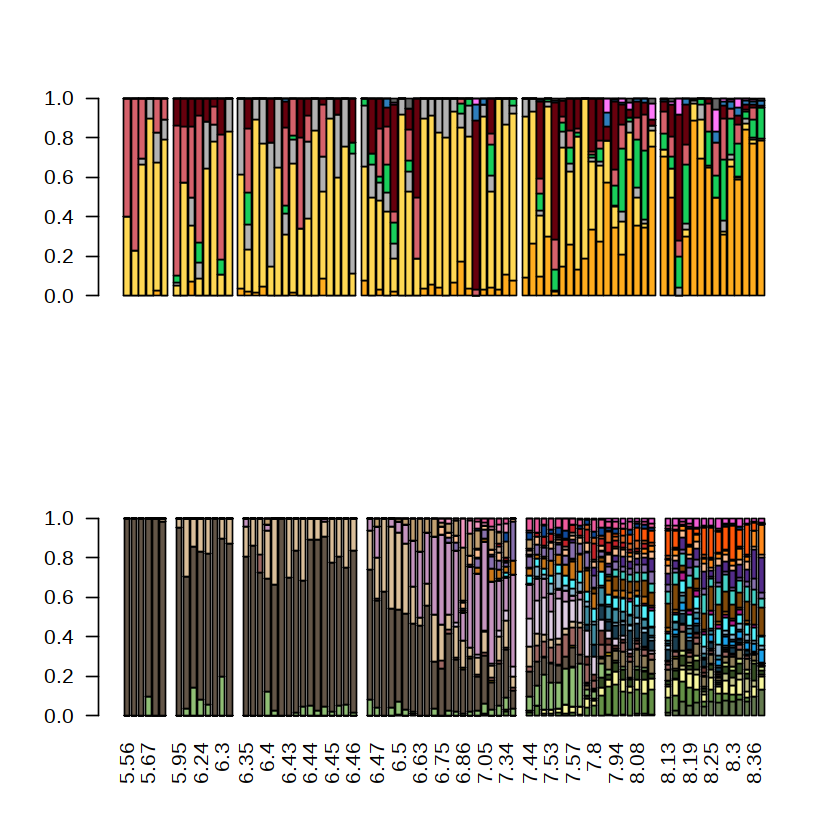

In [7]:
### EDF2c ###
embs <- unique(mat_embexe@cell_metadata[exe_cells_f,"embryo"])
cls_with_exe <- rownames(mat_embexe@cell_metadata)[mat_embexe@cell_metadata$embryo %in% embs]
cls_emb_f <- cls_with_exe[! cls_with_exe %in% exe_cells_f]

ct_ag = table(mc_embexe@colors[mc_embexe@mc[cls_emb_f]],md_embexe[cls_emb_f,"transcriptional_rank"])
ct_ag = ct_ag[mc_embexe@color_key$color[1:38],]
ct_ag_n = t(t(ct_ag)/colSums(ct_ag))
space_between = rep(0.3,ncol(ct_ag_n))
border_age_group = c(6.5,14.5,30.5,51.5,69.5)
space_between[as.integer(border_age_group + 0.5)] = 2

rank_vs_ct = table(mc_exe@colors[mc_exe@mc[exe_cells_f]],mat_exe@cell_metadata[exe_cells_f,"transcriptional_rank"])
rank_vs_ct = rank_vs_ct[mc_exe@color_key$color,]
rank_vs_ct = t(t(rank_vs_ct)/colSums(rank_vs_ct))

emb_age_df = unique(mat_exe@cell_metadata[exe_cells_f,c("embryo","transcriptional_rank","time_bin","developmental_time")])
emb_age_df = emb_age_df[order(emb_age_df$transcriptional_rank),]

space_dist = rep(0.1,ncol(rank_vs_ct))
space_dist[cumsum(table(emb_age_df$time_bin)) + 1] = 0.8
space_dist = space_dist[-length(space_dist)]

par(mfrow = c(2,1))
barplot(rank_vs_ct,
        col = rownames(rank_vs_ct),
        las = 2,
        names.arg = rep("",ncol(ct_ag_n)),
        space = space_dist)

barplot(ct_ag_n,
        col = rownames(ct_ag_n),
        las = 2,
        space = space_between,
        names.arg = round(emb_age_df$developmental_time,2))

pdf("../figs/exe_bars.pdf", w = 10, h = 4, useDingbats = F)
barplot(rank_vs_ct,
        col = rownames(rank_vs_ct),
        las = 2,
        names.arg = rep("",ncol(ct_ag_n)),
        space = space_dist)
dev.off()

In [ ]:
### EDF2d ###
age_time_bin <- tapply(md_exe$developmental_time,md_exe$time_bin,mean)
age_time_bin_df <- data.frame(time_bin = factor(names(age_time_bin)), dev_time_exe_new = as.numeric(age_time_bin))
age_time_bin_df$dev_time_exe_new <- round(age_time_bin_df$dev_time_exe_new,1)

par(mfrow=c(2,1))
plot(as.vector(age_time_bin),
     cex=2,pch=19,col = "black",
     xlab = "Age group",
     ylab = "Estimated Time (Et)")

plot(x = as.vector(age_time_bin),
     y = as.vector(table(mat_exe@cell_metadata[exe_cells_f,"time_bin"])),
     ylim = c(0,1700),
     ylab = "Number of Cells",
     xlab = "Estimated Time (Et)",
     cex=2,pch=19,col = "black")

In [ ]:
tsc_gm <- read.table("../data/tsc_gene_module.txt",header = T, stringsAsFactors = F, sep = " ")[,1]
tgc_gm <- read.table("../data/tgc_gene_module.txt",header = T, stringsAsFactors = F, sep = " ")[,1]
spt_gm <- read.table("../data/spt_gene_module.txt",header = T, stringsAsFactors = F, sep = " ")[,1]
chorion_gm <- read.table("../data/chorion_gene_module.txt",header = T, stringsAsFactors = F, sep = " ")[,1]
gns <- c(tsc_gm,chorion_gm,tgc_gm,spt_gm)

In [ ]:
### EDF2e ###
mc = scdb_mc("exe")
col_to_ct = mc@color_key$group
names(col_to_ct) = mc@color_key$color
ct_to_col = mc@color_key$color
names(ct_to_col) = mc@color_key$group

# gset = scdb_gset("exe")
# feat_genes = intersect(names(gset@gene_set),rownames(mc@e_gc))
feat_genes = intersect(gns,rownames(mc@e_gc))
legc = log2(mc@e_gc + 1e-5)

filtered_mcs = which(mc@colors %in% mc@color_key$color[1:6])

# logistic distance
loc = 1
scale = 0.5
logist_d = function(x) {
    d = abs(legc[feat_genes,] - x)
    d = plogis(d, loc, scale)
    return(colSums(d))
}

mc_mc_logist_dist = apply(legc[feat_genes,], 2, logist_d)

options(repr.plot.width=8, repr.plot.height=8)

annotation_mcs = data.frame(cell_type = col_to_ct[mc@colors])
rownames(annotation_mcs) = c(1:ncol(mc@e_gc))
annotation_colors = list(cell_type = ct_to_col)

pheatmap::pheatmap(mc_mc_logist_dist[filtered_mcs,filtered_mcs],
                   annotation_col = annotation_mcs,
                   annotation_row = annotation_mcs,
                   annotation_colors = annotation_colors,
                   annotation_legend = F,
                   treeheight_row = 0, 
                   treeheight_col = 0,
                   border_color = NA, 
                   show_rownames = F, 
                   show_colnames = F)

In [ ]:
mc_mc_cor <- dist(legc[feat_genes,])

options(repr.plot.width=8, repr.plot.height=8)

annotation_mcs = data.frame(cell_type = col_to_ct[mc@colors])
rownames(annotation_mcs) = c(1:ncol(mc@e_gc))
annotation_colors = list(cell_type = ct_to_col)

pheatmap::pheatmap(mc_mc_cor,
                   annotation_col = annotation_mcs,
                   annotation_row = annotation_mcs,
                   annotation_colors = annotation_colors,
                   annotation_legend = F,
                   treeheight_row = 0, 
                   treeheight_col = 0,
                   border_color = NA, 
                   show_rownames = F, 
                   show_colnames = F)